In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [37]:
from SLIP import imread
name = 'i05june05_static_street_boston_p1010764'
name = 'i05june05_static_street_boston_p1010785'
#name = 'i05june05_static_street_boston_p1010800'
#name = 'i05june05_static_street_boston_p1010806'
#name = 'i05june05_static_street_boston_p1010808'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

#X_roll = 162; Y_roll = 32

In [38]:
from PIL import Image, ImageOps
img_orig = Image.open(impath).convert("L")

In [39]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f)
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010785',
 'barycenters': [(500, 365),
  (227, 435),
  (436, 521),
  (532, 542),
  (871, 474),
  (860, 446),
  (661, 492),
  (595, 481)]}

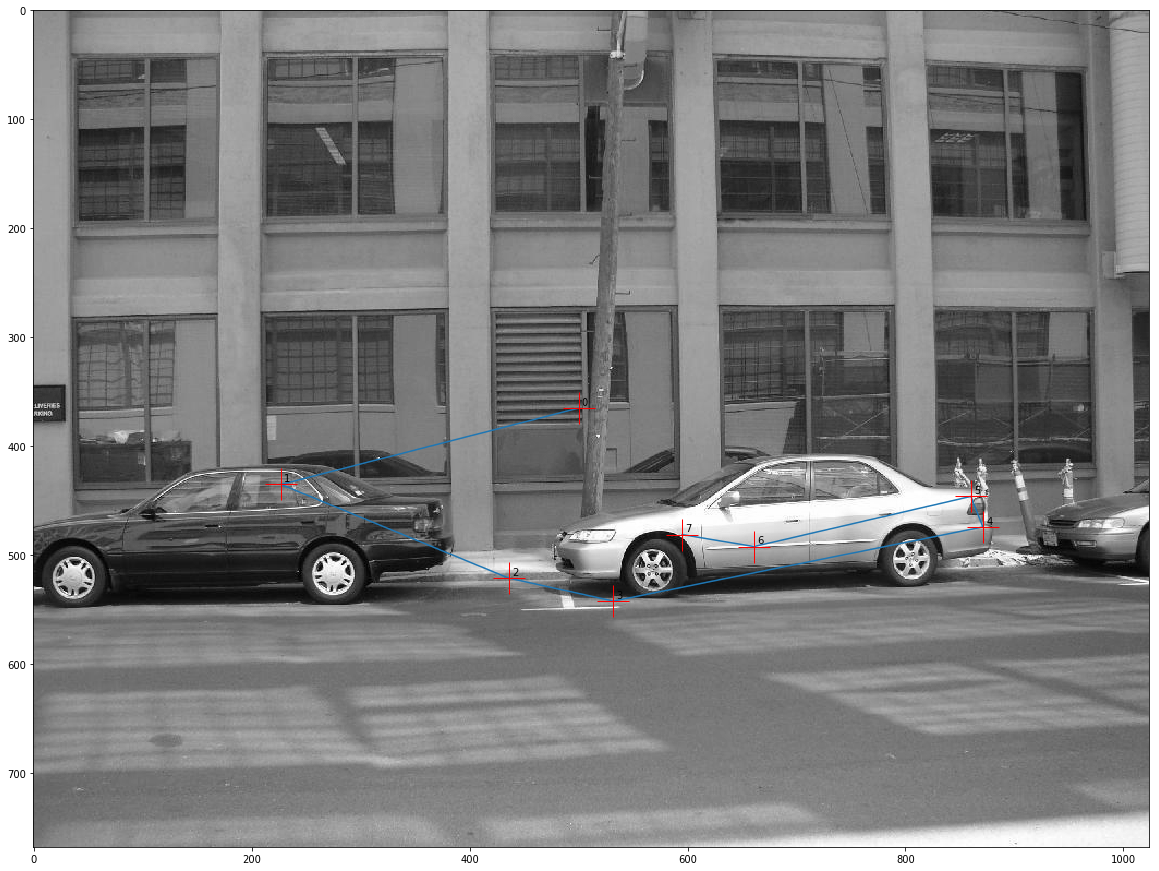

In [53]:
img_orig
img_orig = np.asarray(img_orig)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
loc_data = np.array(loc_dict['barycenters'])
ax.plot(loc_data[:,0], loc_data[:,1])
for i, coord in enumerate(loc_dict['barycenters']):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)

    